# Trabalho Prático 2 - Implementação do Algoritmo de Boosting

**Aluno:** Lucas Moura Veloso

**Matrícula:** 2021708475

**Email:** lmouraveloso@gmail.com 

Neste trabalho iremos implementar o algoritmo AdaBoost do zero e compará-lo com outras implementações e métodos.

O código fonte do algoritmo desenvolvido está contido no arquivo `adaboost.py` e este *notebook* contém os estudos realizados sobre a implementação.

## Configuração inicial do ambiente

In [1]:
# Instalação de bibliotecas necessárias

! pip3 install pandas
! pip3 install matplotlib
! pip3 install numpy
! pip3 install sklearn

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no lon

In [2]:
# Importação de bibliotecas de uso geral

import pandas as pd
import sklearn
import statistics 
import matplotlib.pyplot as plt
from decimal import Decimal
import numpy as np

## Preparação dos dados

In [3]:
# Funções auxiliares para plotagem de gráficos

def add_labels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i])

def round_decimals(decimals):
    decimals_rounded = []
    for dec in decimals:
        decimals_rounded.append(Decimal(dec).quantize(Decimal('0.001')))
    return decimals_rounded

def plot_labeled_values(labels, values, xlabel, ylabel, title, rotate_x = False):
    rounded_values = round_decimals(values)
    plt.figure(figsize = (10, 5))
    plt.bar(labels, values)
    if(rotate_x):
        plt.xticks(rotation=30, ha='right')
    add_labels(labels, rounded_values)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

In [4]:
# Leitura do conjunto de dados

data = pd.read_csv('tic-tac-toe.csv')
display(data.describe())
display(data.head())

,tl,tm,tr,ml,mm,mr,bl,bm,br,class
count,958,958,958,958,958,958,958,958,958,958
unique,3,3,3,3,3,3,3,3,3,2
top,x,x,x,x,x,x,x,x,x,positive
freq,418,378,418,378,458,378,418,378,418,626


,tl,tm,tr,ml,mm,mr,bl,bm,br,class
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive
2,x,x,x,x,o,o,o,o,x,positive
3,x,x,x,x,o,o,o,b,b,positive
4,x,x,x,x,o,o,b,o,b,positive


In [5]:
y = []
for c in data['class']:
    result = 0
    if c == 'positive':
        result = 1
    y.append(result)

In [6]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(['x', 'o', 'b'])
X = data.drop(columns=['class'])
X['tl'] = encoder.transform(X['tl'])
X['tm'] = encoder.transform(X['tm'])
X['tr'] = encoder.transform(X['tr'])
X['ml'] = encoder.transform(X['ml'])
X['mm'] = encoder.transform(X['mm'])
X['mr'] = encoder.transform(X['mr'])
X['bl'] = encoder.transform(X['bl'])
X['bm'] = encoder.transform(X['bm'])
X['br'] = encoder.transform(X['br'])
X.head()

,tl,tm,tr,ml,mm,mr,bl,bm,br
0,2,2,2,2,1,1,2,1,1
1,2,2,2,2,1,1,1,2,1
2,2,2,2,2,1,1,1,1,2
3,2,2,2,2,1,1,1,0,0
4,2,2,2,2,1,1,0,1,0


## Benchmarks

Nesta sessão iremos analisar a performance dos algoritmos AdaBoost e DecisionTree implementados na biblioteca `sklearn` utilizando a mesma métrica de validação cruzada em 5-folds que utilizaremos no restante do trabalho.

Estamos executando estes testes apenas para entender quais seriam valores razoáveis para a acurácia esperada do nosso algoritmo.

In [7]:
# Teste de benchmark com os dados usando o AdaBoostClassifier da biblioteca sklearn

from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import KFold, cross_val_score

# Validação cruzada em 5-folds que será utilizada em todo o trabalho
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

clf = AdaBoostClassifier(n_estimators=100)
print('sklearn adaboost accuracy:', statistics.fmean(cross_val_score(clf, X, y, cv=k_fold, n_jobs=1)) * 100)

sklearn adaboost accuracy: 84.34173211169285


In [8]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=0)
print('sklearn decision tree accuracy:', statistics.fmean(cross_val_score(clf, X, y, cv=k_fold, n_jobs=1)) * 100)

sklearn decision tree accuracy: 87.36365619546248


## Execução do algoritmo implementado

Nesta sessão executaremos o código do AdaBoost implementado no arquivo `adaboost.py` e geraremos gráficos para discussão na próxima sessão.

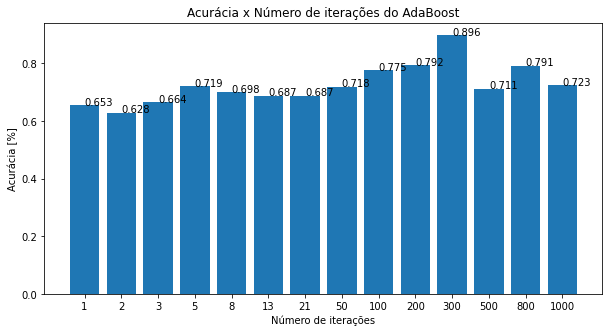

In [9]:
from adaboost import train_adaboost, predict_adaboost

def run_adaboost(n_iter):
    accuracy_fold = []
    for train_index, test_index in k_fold.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = np.array(y)[train_index], np.array(y)[test_index]
        clf = train_adaboost(X_train, y_train, n_iter)
        y_pred = predict_adaboost(clf, X_test)
        errors = 0
        for i in range(len(y_test)):
            if y_pred[i] != y_test[i]:
                errors = errors + 1
        accuracy_fold.append((len(y_test)-errors)/len(y_test))
    return statistics.fmean(accuracy_fold)

n_iters = [1, 2, 3, 5, 8, 13, 21, 50, 100, 200, 300, 500, 800, 1000]
accuracies = []
for i in range(len(n_iters)):
    accuracies.append(run_adaboost(n_iters[i]))

plot_labeled_values(['1', '2', '3', '5', '8', '13', '21', '50', '100', '200', '300', '500', '800', '1000'], 
                    accuracies, 
                    'Número de iterações', 
                    'Acurácia [%]', 
                    'Acurácia x Número de iterações do AdaBoost')

## Conclusão

A tabela abaixo condensa os resultados mais interessantes obtidos, as análises de acurácia foram executadas com a métrica de erro simples em validação cruzada com 5-folds.

|Método|Acurácia [%]|Número de iterações|
|-|-|-|
|Decision Tree (`sklearn`)|87.36|N/A|
|AdaBoost (`sklearn`)|84.34|100|
|AdaBoost (implementado em `adaboost.py`)|77.5|100|
|AdaBoost (implementado em `adaboost.py`)|89.6|300|

Podemos perceber que para o mesmo número de iterações a nossa implementação foi inferior às implementações da biblioteca `sklearn`, porém para 300 iterações tivemos resultados muito interessantes beirando os 90% de acurácia.

Um resultado curioso foi que após 300 iterações o valor da acurácia obtida pelo algoritmo implementado começou a oscilar e cair para patamares inferiores, o que indica que a quantidade de preditores começa a interferir nos resultados negativamente, provavelmente devido ao tamanho restrito da nossa base de dados.